In [1]:
import cv2
import os
from keras import regularizers
import numpy as np
import keras
from keras import layers, models
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import librosa
import matplotlib.pyplot as plt
import random
from keras.optimizers import Adam
from sklearn.metrics import classification_report

2024-08-04 04:57:02.597476: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 04:57:02.622229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 04:57:02.657259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 04:57:02.667611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 04:57:02.694263: I tensorflow/core/platform/cpu_feature_guar

# Importando imagenes

In [2]:
path = os.path.join('.', 'Data', 'images_original')
images = []
images_labels = []

label_dict = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

# Preparando paths y labels
image_paths = []
for i, s in enumerate(label_dict.values()):
    images_path = os.path.join(path, s)
    images_png = os.listdir(images_path)
    image_paths.extend([os.path.join(images_path, img_name) for img_name in images_png])
    images_labels.extend([i] * len(images_png))

# Leyendo las imagenes
for img_path, label in zip(image_paths, images_labels):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    images.append(img)
    
images = np.array(images, dtype=np.float32)
images_labels = np.array(images_labels, dtype=np.float32)

# Randomizando y normalizando
shuffled_indexes = np.random.permutation(len(images))
images = images[shuffled_indexes]
images_labels = images_labels[shuffled_indexes]
images /= 255.0

# Dividiendo el dataset

In [3]:
# Train 0.8 - Val 0.1 - Test 0.1
train_size = int(0.8 * len(images))
val_size = int(0.1 * len(images))

x_train, x_val, x_test = np.split(images, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(images_labels, [train_size, train_size + val_size])

In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [5]:
y_train.shape

(799, 10)

# Data Augmentation

In [6]:
def add_white_noise(spectrogram, noise_level=0.01):
    noise = np.random.randn(*spectrogram.shape) * noise_level
    return spectrogram + noise

x_train_augmented = np.array([add_white_noise(img, noise_level=0.005) for img in x_train])
x_train = np.concatenate((x_train, x_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

shuffled_indexes = np.random.permutation(len(x_train))
x_train = x_train[shuffled_indexes]
y_train = y_train[shuffled_indexes]

# Arquitectura del modelo

In [7]:
from keras import layers, models

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(218, 336, 1), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

/anaconda/envs/jupyter_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-04 04:57:45.509231: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
model.compile(optimizer = Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 336, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 168, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 109, 168, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 168, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 54, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 72576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     9,289,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,365,642 (35.73 MB)

 Trainable params: 9,365,642 (35.73 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
y_train.ndim

2

In [10]:
filepath = 'modelo_definitivo2.keras'

checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

logs = model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val), batch_size=64, callbacks=[checkpoint], shuffle=True)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1328 - loss: 2.6807
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to modelo_definitivo4.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.1341 - loss: 2.6769 - val_accuracy: 0.2222 - val_loss: 2.3021
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2355 - loss: 2.3321
Epoch 2: val_accuracy improved from 0.22222 to 0.43434, saving model to modelo_definitivo4.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2366 - loss: 2.3301 - val_accuracy: 0.4343 - val_loss: 2.0696
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3476 - loss: 2.0094
Epoch 3: val_accuracy improved from 0.43434 to 0.50505, saving model to modelo_definitivo4.keras
25/25 ━━━━━

# Resultados y evaluaciones de desempeño

### Gráficos de accuracy y loss

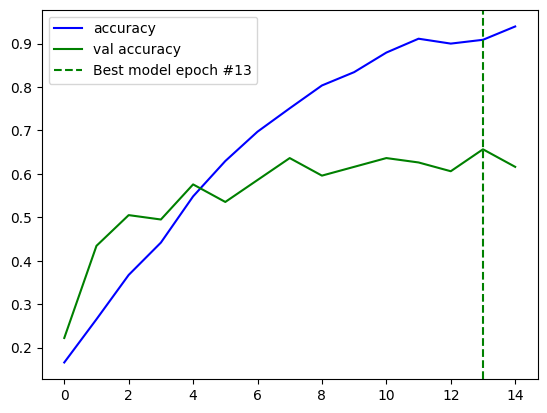

In [11]:
max_acc = max(logs.history['accuracy'])
max_val_acc = max(logs.history['val_accuracy'])
max_acc_epoch = logs.history['accuracy'].index(max_acc)
max_val_acc_epoch = logs.history['val_accuracy'].index(max_val_acc)


plt.figure()
plt.plot(logs.history['accuracy'], c='b', label='accuracy')
plt.plot(logs.history['val_accuracy'], c='g', label='val accuracy')
plt.axvline(x=max_val_acc_epoch, color='g', linestyle='--', label=f'Best model epoch #{max_val_acc_epoch}')
plt.legend()
plt.show()

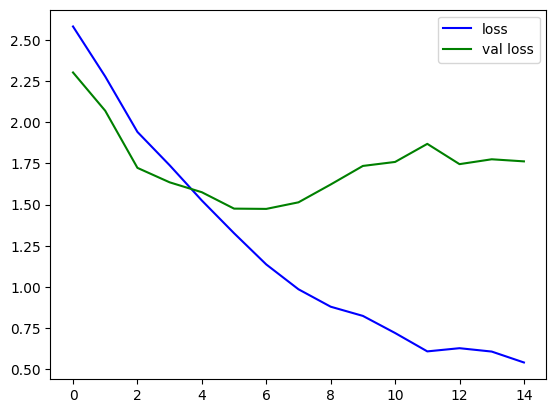

In [12]:
plt.figure()
plt.plot(logs.history['loss'], c = 'b', label = 'loss')
plt.plot(logs.history['val_loss'],c = 'g', label = 'val loss')
all_loss = logs.history['loss']
plt.legend()
plt.show()

In [14]:
model_loaded = keras.models.load_model('modelo_definitivo2.keras')

In [15]:
model_loaded.evaluate(x_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7116 - loss: 1.3312


[1.3248766660690308, 0.6930692791938782]

In [16]:
prueba = model_loaded.predict(x_test[2].reshape(1, 218, 336, 1))
print(np.argmax(prueba))
print(y_test[2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### Matríz de confusión

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


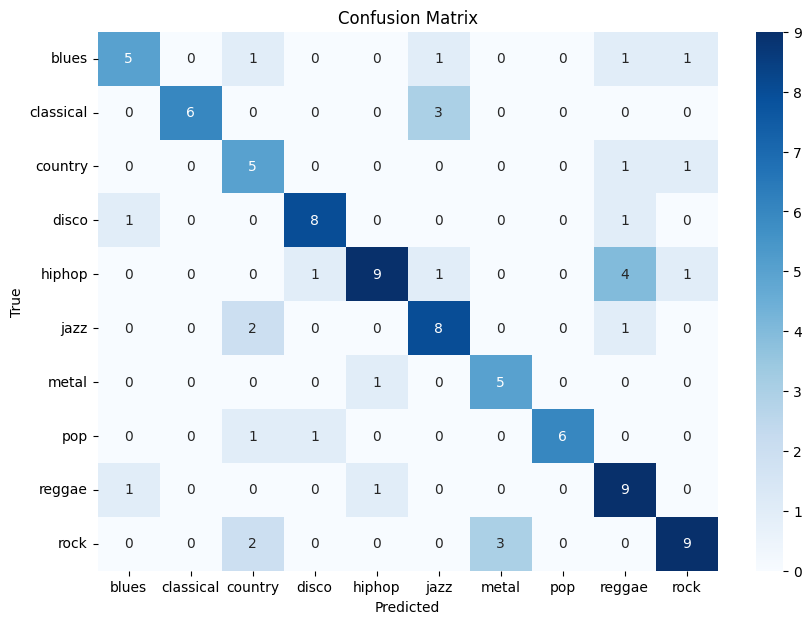

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

labels = [label_dict[i] for i in range(len(label_dict))]

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import pickle

with open('training_logs.pkl', 'wb') as file:
    pickle.dump(logs.history, file)

### Reporte de resultados (f1 score, accuracy y r)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

       blues       0.71      0.56      0.62         9
   classical       1.00      0.67      0.80         9
     country       0.45      0.71      0.56         7
       disco       0.80      0.80      0.80        10
      hiphop       0.82      0.56      0.67        16
        jazz       0.62      0.73      0.67        11
       metal       0.62      0.83      0.71         6
         pop       1.00      0.75      0.86         8
      reggae       0.53      0.82      0.64        11
        rock       0.75      0.64      0.69        14

    accuracy                           0.69       101
   macro avg       0.73      0.71      0.70       101
weighted avg       0.74      0.69      0.70       101

